In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import time
import re

In [2]:
#read sample dataset
data = pd.read_csv("sample_data.csv")
items = pd.read_csv("items.csv")
data.head()

,sid,id,order_number
0,10,2,1
1,10,4,1
2,10,3,2
3,10,2,3
4,10,1,4


In [3]:
# Merge to get item IDs with user and order_number
merged = items.merge(data[['id','sid','order_number']], on='id')
merged = merged.sort_values(['sid','item'])
merged.head()

,id,item,sid,order_number
0,1,a,10,4
5,2,b,10,1
6,2,b,10,3
15,3,c,10,2
16,3,c,10,4


In [4]:
# Create dictionary: id → item name to be used later for interpreting sequence
item_dict = dict(zip(items['id'], items['item']))

In [5]:
# Group into sequences
sequences = []
for user_id, user_data in merged.groupby("sid"):    
    sequence = []    
    for order_number, item in user_data.groupby("order_number"):        
        items = item["id"].tolist()        
        sequence.append(items)    
    sequences.append(sequence)

In [6]:
# Save in data readable by spmf
with open("spmf_data.txt", "w") as f:    
    for sequence in sequences:        
        line = ""        
        for event in sequence:            
            for item in event:
                line += str(item) + " "            
            line += "-1 "        
        line += "-2\n"        
        f.write(line)
print("SPMF readable data file created successfully.")

SPMF readable data file created successfully.


In [7]:
#Function to read SPMF output
def read_spmf_output(filename):    
    patterns = []    
    with open(filename, "r") as f:        
        for line in f:            
            pattern_part, support_part = line.strip().split("#SUP:")            
            support = int(support_part.strip())            
            events = pattern_part.strip().split("-1")            
            clean_events = []            
            for event in events:                
                event = event.strip()                
                if event:                    
                    ids = [int(x) for x in event.split()]                    
                    clean_events.append(ids)            
            patterns.append((clean_events, support))    
    return patterns

In [47]:
#Function to run the algorithm
def run_spmf_with_stats(algorithm, input_file, output_file, minsup):    
    result = subprocess.run(
        ["java", "-jar", "spmf.jar", "run", algorithm, input_file, output_file, minsup],
        capture_output=True,
        text=True
    )    
    output = result.stdout
    #print(output)
    # Extract runtime
    time_match = re.search(r"Total time ~\s*(\d+)", output)
    runtime = int(time_match.group(1)) if time_match else None
    
    # Extract max memory
    memory_match = re.search(r"\s*Max memory \(mb\)\s*:\s*([\d.]+)", output)
    memory = float(memory_match.group(1)) if memory_match else None
    
    return runtime, memory, output

In [26]:
#function to display the frequent items from the ouput
#Convert the pattern from id to item format to easily read the data
def convert_pattern(pattern):
    named = []
    
    for event in pattern:
        named_event = [item_dict[id] for id in event]
        named.append(named_event)
    
    return named

In [28]:
#function to view support distribution
def support_distribution(patterns):    
    support_counts = {}    
    for pattern, support in patterns:        
        support_counts[support] = support_counts.get(support, 0) + 1
    
    df = pd.DataFrame(
        support_counts.items(),
        columns=["Support", "Number of Patterns"]
    ).sort_values("Support")
    
    return df

### GSP Algorithm

In [19]:
#run GSP Algorithm
gsp_runtime, gsp_memory, gsp_log = run_spmf_with_stats(
    "GSP",
    "spmf_data.txt",
    "gsp_output.txt",
    "0.4"
)

print("Runtime:", gsp_runtime, "ms")
print("Max memory:", gsp_memory, "MB")

Runtime: 22 ms
Max memory: 12.442024230957031 MB


In [22]:
#read back the results in jupyter and show the no of frequent patterns
gsp_patterns = read_spmf_output('gsp_output.txt')
print("GSP patterns:", len(gsp_patterns))

GSP patterns: 53


In [24]:
#print GSP patterns
for pattern, support in gsp_patterns:    
    named_pattern = convert_pattern(pattern)    
    sequence = " → ".join(
        [" + ".join(event) for event in named_pattern]
    )    
    print(f"{sequence}   (Support: {support})")

a   (Support: 3)
b   (Support: 5)
c   (Support: 4)
d   (Support: 3)
e   (Support: 3)
f   (Support: 2)
a → a   (Support: 2)
a → b   (Support: 2)
b → a   (Support: 3)
c → a   (Support: 2)
d → a   (Support: 2)
b → b   (Support: 4)
b → c   (Support: 4)
c → b   (Support: 3)
b → d   (Support: 2)
d → b   (Support: 2)
b + d   (Support: 2)
b → e   (Support: 3)
b → f   (Support: 2)
f → b   (Support: 2)
b + f   (Support: 2)
c → d   (Support: 2)
d → c   (Support: 2)
c + e   (Support: 2)
f → f   (Support: 2)
a → b → a   (Support: 2)
a → b → b   (Support: 2)
b → b → a   (Support: 2)
b → b → c   (Support: 2)
b → b → f   (Support: 2)
b → c → a   (Support: 2)
b → c → b   (Support: 3)
b → c → d   (Support: 2)
b → c + e   (Support: 2)
c → b → a   (Support: 2)
d → b → a   (Support: 2)
d → b → c   (Support: 2)
b + d → a   (Support: 2)
b + d → b   (Support: 2)
b + d → c   (Support: 2)
f → b → f   (Support: 2)
b + f → b   (Support: 2)
b + f → f   (Support: 2)
d → c → a   (Support: 2)
d → c → b   (Support: 2)

In [29]:
df_gsp_support = support_distribution(gsp_patterns)
df_gsp_support

,Support,Number of Patterns
3,2,42
0,3,7
2,4,3
1,5,1


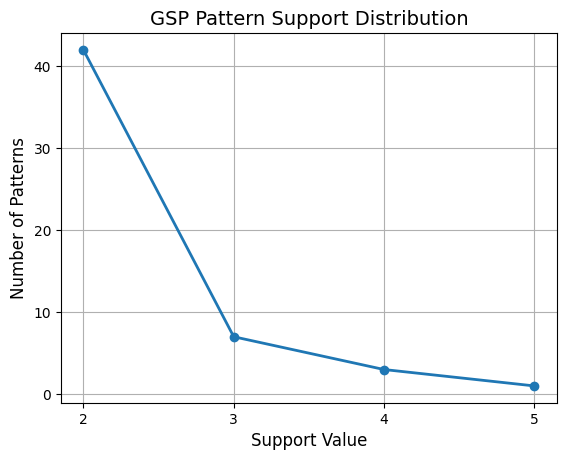

In [32]:
#graph the gsp_support distribution
algo = "GSP"
plt.figure()

plt.plot(
    df_gsp_support["Support"],
    df_gsp_support["Number of Patterns"],
    marker='o',
    linewidth=2
)

plt.xticks(df_gsp_support["Support"])

plt.xlabel("Support Value", fontsize=12)
plt.ylabel("Number of Patterns", fontsize=12)
plt.title(f"{algo} Pattern Support Distribution", fontsize=14)

plt.grid(True)

plt.show()

### SPADE

In [34]:
#run SPADE Algorithm
spade_runtime, spade_memory, spade_log = run_spmf_with_stats(
    "SPADE",
    "spmf_data.txt",
    "spade_output.txt",
    "0.4"
)

print("Runtime:", spade_runtime, "ms")
print("Max memory:", spade_memory, "MB")

Runtime: 8 ms
Max memory: 12.441986083984375 MB


In [35]:
#read back the results in jupyter and show the no of frequent patterns
spade_patterns = read_spmf_output('spade_output.txt')
print("SPADE patterns:", len(spade_patterns))

SPADE patterns: 53


In [36]:
#print SPADE patterns
for pattern, support in spade_patterns:    
    named_pattern = convert_pattern(pattern)    
    sequence = " → ".join(
        [" + ".join(event) for event in named_pattern]
    )    
    print(f"{sequence}   (Support: {support})")

a   (Support: 3)
b   (Support: 5)
c   (Support: 4)
d   (Support: 3)
e   (Support: 3)
f   (Support: 2)
f → f   (Support: 2)
b + f   (Support: 2)
b → f   (Support: 2)
f → b   (Support: 2)
f → b → f   (Support: 2)
c + e   (Support: 2)
b → e   (Support: 3)
c → d   (Support: 2)
d → c   (Support: 2)
b + d   (Support: 2)
b → d   (Support: 2)
d → b   (Support: 2)
d → a   (Support: 2)
d → b → a   (Support: 2)
d → c → a   (Support: 2)
d → c → b   (Support: 2)
d → b → c   (Support: 2)
d → c → b → a   (Support: 2)
b → c   (Support: 4)
c → b   (Support: 3)
c → a   (Support: 2)
c → b → a   (Support: 2)
b → b   (Support: 4)
a → b   (Support: 2)
b → a   (Support: 3)
b → b → a   (Support: 2)
b → c → a   (Support: 2)
b + d → a   (Support: 2)
b → c → b   (Support: 3)
b → b → c   (Support: 2)
b + d → b   (Support: 2)
b → b → f   (Support: 2)
b + f → b   (Support: 2)
b → c → d   (Support: 2)
b + d → c   (Support: 2)
b → c + e   (Support: 2)
b → c → b → a   (Support: 2)
b + d → b → c   (Support: 2)
b + d → 

In [37]:
df_spade_support = support_distribution(spade_patterns)
df_spade_support

,Support,Number of Patterns
3,2,42
0,3,7
2,4,3
1,5,1


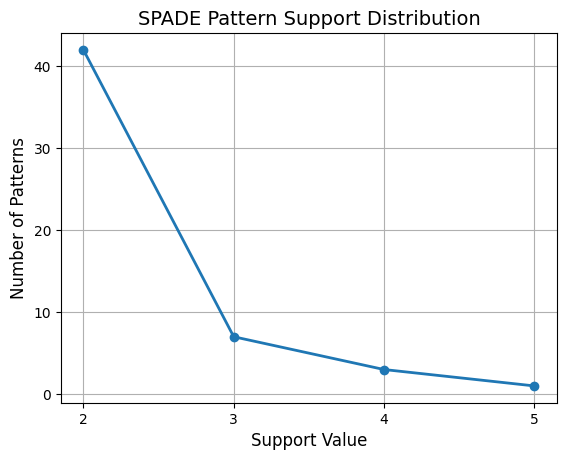

In [38]:
#graph the gsp_support distribution
algo = "SPADE"
plt.figure()

plt.plot(
    df_gsp_support["Support"],
    df_gsp_support["Number of Patterns"],
    marker='o',
    linewidth=2
)

plt.xticks(df_gsp_support["Support"])

plt.xlabel("Support Value", fontsize=12)
plt.ylabel("Number of Patterns", fontsize=12)
plt.title(f"{algo} Pattern Support Distribution", fontsize=14)

plt.grid(True)

plt.show()

### PrefixSpan

In [48]:
#run SPADE Algorithm
prefixspan_runtime, prefixspan_memory, prefixspan_log = run_spmf_with_stats(
    "PrefixSpan",
    "spmf_data.txt",
    "prefixspan_output.txt",
    "0.4"
)

print("Runtime:", prefixspan_runtime, "ms")
print("Max memory:", prefixspan_memory, "MB")

Runtime: 3 ms
Max memory: 11.779716491699219 MB


In [49]:
#read back the results in jupyter and show the no of frequent patterns
prefixspan_patterns = read_spmf_output('prefixspan_output.txt')
print("PrefixSpan patterns:", len(prefixspan_patterns))

PrefixSpan patterns: 53


In [50]:
#print PrefixSpan patterns
for pattern, support in prefixspan_patterns:    
    named_pattern = convert_pattern(pattern)    
    sequence = " → ".join(
        [" + ".join(event) for event in named_pattern]
    )    
    print(f"{sequence}   (Support: {support})")

a   (Support: 3)
a → a   (Support: 2)
a → b   (Support: 2)
a → b → a   (Support: 2)
a → b → b   (Support: 2)
b   (Support: 5)
b + d   (Support: 2)
b + d → a   (Support: 2)
b + d → b   (Support: 2)
b + d → b → a   (Support: 2)
b + d → b → c   (Support: 2)
b + d → c   (Support: 2)
b + d → c → a   (Support: 2)
b + d → c → b   (Support: 2)
b + d → c → b → a   (Support: 2)
b + f   (Support: 2)
b + f → b   (Support: 2)
b + f → b → f   (Support: 2)
b + f → f   (Support: 2)
b → a   (Support: 3)
b → b   (Support: 4)
b → b → a   (Support: 2)
b → b → c   (Support: 2)
b → b → f   (Support: 2)
b → c   (Support: 4)
b → c + e   (Support: 2)
b → c → a   (Support: 2)
b → c → b   (Support: 3)
b → c → b → a   (Support: 2)
b → c → d   (Support: 2)
b → d   (Support: 2)
b → e   (Support: 3)
b → f   (Support: 2)
c   (Support: 4)
c + e   (Support: 2)
c → a   (Support: 2)
c → b   (Support: 3)
c → b → a   (Support: 2)
c → d   (Support: 2)
d   (Support: 3)
d → a   (Support: 2)
d → b   (Support: 2)
d → b → a   (S

In [51]:
df_prefixspan_support = support_distribution(prefixspan_patterns)
df_prefixspan_support

,Support,Number of Patterns
1,2,42
0,3,7
3,4,3
2,5,1


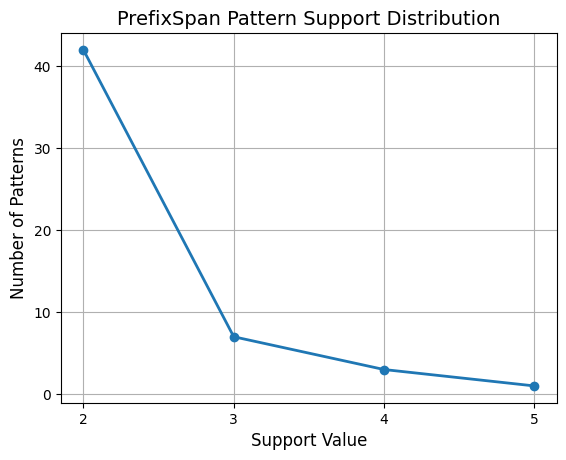

In [52]:
#graph the gsp_support distribution
algo = "PrefixSpan"
plt.figure()

plt.plot(
    df_gsp_support["Support"],
    df_gsp_support["Number of Patterns"],
    marker='o',
    linewidth=2
)

plt.xticks(df_gsp_support["Support"])

plt.xlabel("Support Value", fontsize=12)
plt.ylabel("Number of Patterns", fontsize=12)
plt.title(f"{algo} Pattern Support Distribution", fontsize=14)

plt.grid(True)

plt.show()

### COMPARE SPADE, GSP, PrefixSpan Performance in Terms or Memory, and Time

In [55]:
results = []
results.append({
        "Algorithm": "GSP",
        "Runtime (ms)": gsp_runtime,
        "Max Memory (MB)": gsp_memory
    })
results.append({
        "Algorithm": "SPADE",
        "Runtime (ms)": spade_runtime,
        "Max Memory (MB)": spade_memory
    })
results.append({
        "Algorithm": "PrefixSpan",
        "Runtime (ms)": prefixspan_runtime,
        "Max Memory (MB)": prefixspan_memory
    })
df_results = pd.DataFrame(results)

In [56]:
df_results

,Algorithm,Runtime (ms),Max Memory (MB)
0,GSP,22,12.442024
1,SPADE,8,12.441986
2,PrefixSpan,3,11.779716


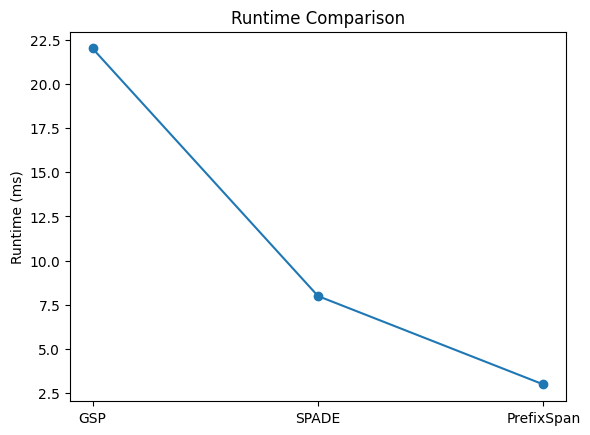

In [57]:
#plot runtime comparison
plt.figure()
plt.plot(df_results["Algorithm"], df_results["Runtime (ms)"], marker='o')
plt.title("Runtime Comparison")
plt.ylabel("Runtime (ms)")
plt.show()

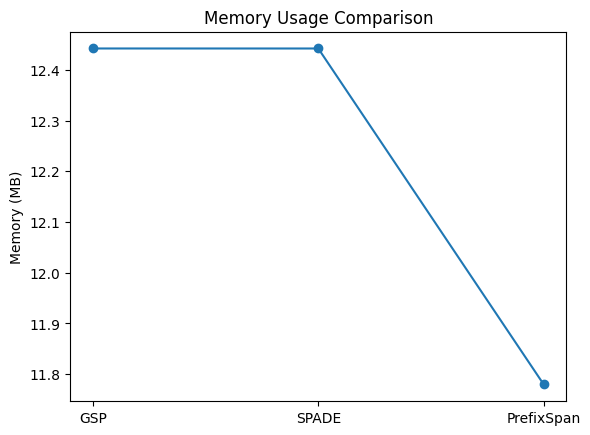

In [58]:
#plot memory comparison
plt.figure()
plt.plot(df_results["Algorithm"], df_results["Max Memory (MB)"], marker='o')
plt.title("Memory Usage Comparison")
plt.ylabel("Memory (MB)")
plt.show()